<h2>Data Loading and Preparation</h2>

In [76]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    elif x == 8:
        return 'No_Bat'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted





In [77]:

from sklearn.model_selection import train_test_split

import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint

from PIL import Image

from matplotlib import pyplot as plt
import os
import pandas as pd

In [78]:
image_folder_path = '../../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [79]:
X_all = []
Y_all = []

image_folder_path = '../../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
#     spectrogram = spectrogram.convert('RGB')
#     spectrogram = spectrogram.resize((168, 112))  
    
    spectrogram = spectrogram.convert('L')
    spectrogram = spectrogram.resize((28, 28))  
    
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


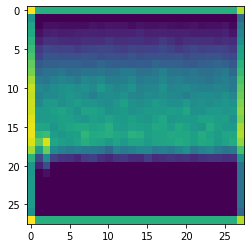

In [80]:
plt.imshow(X_all[1])

In [81]:
#Load Noise
image_folder_path = '../../data/noise'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
#     spectrogram = spectrogram.convert('RGB')
#     spectrogram = spectrogram.resize((168, 112))
    spectrogram = spectrogram.convert('L')
    spectrogram = spectrogram.resize((28, 28))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(8)


In [82]:
X_all = np.array(X_all)
X_all = np.expand_dims(X_all, axis=1) #Only for GreyScale
X_all.shape

(3426, 1, 28, 28)

In [83]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

#X_all = np.moveaxis(X_all, -1, 1) #For pytorch if RGB

Y_all = Y_all.astype(int)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all = (X_all - 127.5) / 127.5

#Y_all = np_utils.to_categorical(Y_all, num_classes=9) 


(3426, 1, 28, 28)
(3426,)


In [84]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)
print(Y_train.shape)

(2740,)


In [85]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

In [86]:
tensor_x_train = torch.from_numpy(X_train) # transform to torch tensor
tensor_y_train = torch.from_numpy(Y_train)

In [87]:
tensor_x_train.shape

torch.Size([2740, 1, 28, 28])

In [88]:
tensor_y_train.shape

torch.Size([2740])

In [89]:
tensor_x_test =  torch.from_numpy(X_test) 
tensor_y_test =  torch.from_numpy(Y_test)

In [90]:
tensor_x_test.shape

torch.Size([686, 1, 28, 28])

In [91]:
tensor_y_test[1]

tensor(6)

In [92]:
trainset  = TensorDataset(tensor_x_train,tensor_y_train) # create your datset
testset  = TensorDataset(tensor_x_test,tensor_y_test) # create your datset

## Hyper Param and Data Loader

In [54]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [93]:
# hyper-parameters
batch_size = 32
keep_prob = 1 # 0.7

In [94]:
train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False)

<h2> Model Definition and Training </h2>

In [95]:
import torchvision
import torchvision.transforms as transforms
import torch

In [96]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(p=1 - keep_prob))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out


# instantiate CNN model
model = CNN()
model

/home/team9/anaconda3/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
  )
  (fc1): Linear(in_features=2048, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=2048, out_features=625, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
  )
  (fc2): Linear(in_features=625, out_features=10, bias=True)
)

In [97]:
for param in model.parameters():
    print(param.size())

torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([625, 2048])
torch.Size([625])
torch.Size([10, 625])
torch.Size([10])


In [98]:

learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()    # Softmax is internally computed.
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [101]:
from torch.autograd import Variable

In [102]:
print('Training the Deep Learning network ...')
train_cost = []
train_accu = []

training_epochs = 15
total_batch = len(train_loader) // batch_size


for epoch in range(training_epochs):
    avg_cost = 0
    for i, (batch_X, batch_Y) in enumerate(train_loader):
        X = Variable(batch_X)    # image is already size of (28x28), no reshape
        Y = Variable(batch_Y)    # label is not one-hot encoded

        optimizer.zero_grad() # <= initialization of the gradients
        
        # forward propagation
        hypothesis = model(X)
        cost = criterion(hypothesis, Y) # <= compute the loss function
        
        # Backward propagation
        cost.backward() # <= compute the gradient of the loss/cost function     
        optimizer.step() # <= Update the gradients
             
        # Print some performance to monitor the training
        prediction = hypothesis.data.max(dim=1)[1]
        train_accu.append(((prediction.data == Y.data).float().mean()).item())
        train_cost.append(cost.item())   
        if i % 200 == 0:
            print("Epoch= {},\t batch = {},\t cost = {:2.4f},\t accuracy = {}".format(epoch+1, i, train_cost[-1], train_accu[-1]))
       
        avg_cost += cost.data / total_batch

    print("[Epoch: {:>4}], averaged cost = {:>.9}".format(epoch + 1, avg_cost.item()))


print('Learning Finished!')
#  _, argmax = torch.max(outputs, 1)
accuracy = (labels == argmax.squeeze()).float().mean()

Training the Deep Learning network ...
Epoch= 1,	 batch = 0,	 cost = 2.3232,	 accuracy = 0.0
[Epoch:    1], averaged cost = 58.1539955
Epoch= 2,	 batch = 0,	 cost = 0.6859,	 accuracy = 0.78125
[Epoch:    2], averaged cost = 38.6307678
Epoch= 3,	 batch = 0,	 cost = 0.4967,	 accuracy = 0.84375
[Epoch:    3], averaged cost = 27.9277554
Epoch= 4,	 batch = 0,	 cost = 0.2451,	 accuracy = 0.90625
[Epoch:    4], averaged cost = 20.1776524
Epoch= 5,	 batch = 0,	 cost = 0.1216,	 accuracy = 0.96875
[Epoch:    5], averaged cost = 16.1923275
Epoch= 6,	 batch = 0,	 cost = 0.1518,	 accuracy = 0.9375
[Epoch:    6], averaged cost = 13.5239391
Epoch= 7,	 batch = 0,	 cost = 0.0770,	 accuracy = 0.96875
[Epoch:    7], averaged cost = 11.0124378
Epoch= 8,	 batch = 0,	 cost = 0.0810,	 accuracy = 0.96875
[Epoch:    8], averaged cost = 10.0719252
Epoch= 9,	 batch = 0,	 cost = 0.0713,	 accuracy = 0.96875
[Epoch:    9], averaged cost = 8.49437046
Epoch= 10,	 batch = 0,	 cost = 0.0281,	 accuracy = 1.0
[Epoch:   1

NameError: name 'argmax' is not defined